In [2]:
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import uncertainties
import urllib2
%matplotlib inline
%load_ext ipycache
import probfit
import iminuit
import copy
import numba
import os
%config InlineBackend.figure_format = 'svg'
exec(open('settings.py').read(), globals())

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


In [3]:
%%cache outgrowth.pkl outgrowth
outgrowth_file = urllib2.urlopen('https://raw.githubusercontent.com/fabianrost84/Rost-Rodrigo-Albors-et-al-2016/v0.1-alpha/data/outgrowth.csv')
outgrowth = pd.read_csv(outgrowth_file)
outgrowth['length'] = outgrowth['length'] / 1000.0

[Skipped the cell's code and loaded variables outgrowth from file '/media/500G/fabian/work/axolotl/git/axolotl-calculations-phd/outgrowth.pkl'.]


In [4]:
mean_outgrowth = outgrowth.groupby('time').agg(['mean', 'sem'])
mean_outgrowth

length          
          mean       sem
time                    
0.0   0.000000  0.000000
2.0   0.056500  0.009006
3.0   0.163286  0.020837
4.0   0.451750  0.041292
6.0   1.278500  0.056770
8.0   2.257250  0.072343

In [5]:
minuits = {}

# LS approach

## Fit with Malthusian growth model

In [6]:
def malthusian_model(time, L0, r):
    return L0 * (sp.exp(r * time) - 1.0) 

### Assuming $L_0 = 500 \mu m$

In [7]:
L0 = 0.5

In [8]:
chi2_malt_500 = probfit.Chi2Regression(malthusian_model, sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['malt_500'] = iminuit.Minuit(chi2_malt_500, 
                        L0 = 0.5, error_L0 = 0.1, fix_L0 = True, 
                        r = 1.0, error_r = 0.1)

minuits['malt_500'].migrad();

FCN = 501.994752294 
 TOTAL NCALL = 64 
 NCALLS = 64 
 
 
 EDM = 9.22796792103e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.000000e-01,0.000000e+00,0.000000e+00,,,FIXED
2,r,1.683228e-01,3.229909e-03,0.000000e+00,0.000000e+00,,,


### Fitting $L_0$ and $r$

In [9]:
chi2_malt = probfit.Chi2Regression(malthusian_model,sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['malt'] = iminuit.Minuit(chi2_malt, L0 = 3.8, r = 0.001, error_L0 = 0.1, error_r = 0.1, limit_L0 = (0.5, None))

minuits['malt'].migrad();

FCN = 501.994752553 
 TOTAL NCALL = 307 
 NCALLS = 307 
 
 
 EDM = 2.6829797996e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.658986e-03,0.000000e+00,0.000000e+00,0.5,,
2,r,1.683228e-01,3.229911e-03,0.000000e+00,0.000000e+00,,,


### Biphasic model

In [10]:
@numba.njit
def biphase_model(time, L0, r1, r2, tswitch):
    if tswitch <= 0:
        return L0 * (sp.exp(r2 * time) - 1.0) 
    else:
        if time <= tswitch:
            return L0 * (sp.exp(r1 * time) - 1.0) 
        else:
            L1 = L0 * (sp.exp(r1 * tswitch) - 1.0) + L0
            return L1 * (sp.exp(r2 * (time - tswitch)) - 1.0)  + L1 - L0

In [11]:
chi2_biphase_500 = probfit.Chi2Regression(biphase_model,
                                sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['biphase_500'] = iminuit.Minuit(chi2_biphase_500, L0 = 0.5, error_L0 = 0.1, fix_L0 = True, limit_L0 = (0.5, None),
                                        r1 = 0.10, r2 = 0.1, tswitch = 3.0,\
                                        error_r1 = 0.01, error_r2 = 0.01, error_tswitch = 0.1,
                                        limit_r1 = (0, None), limit_r2 = (0, None))

minuits['biphase_500'].migrad();

FCN = 12.195768939 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 1.75233761866e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.000000e-01,0.000000e+00,0.000000e+00,0.5,,FIXED
2,r1,5.353064e-02,8.090032e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,2.831553e-01,7.386990e-03,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.282289e+00,1.527460e-01,0.000000e+00,0.000000e+00,,,


In [12]:
minuits['biphase_500'].minos('tswitch', sigma = 2)

Error,-0.657397347273,0.307023008118
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{'tswitch': {'lower_new_min': False, 'upper': 0.30702300811770783, 'lower': -0.6573973472728801, 'at_lower_limit': False, 'min': 2.2822890671765617, 'at_lower_max_fcn': False, 'is_valid': True, 'upper_new_min': False, 'at_upper_limit': False, 'lower_valid': True, 'upper_valid': True, 'at_upper_max_fcn': False, 'nfcn': 226}}

In [13]:
chi2_biphase_800 = probfit.Chi2Regression(biphase_model,
                                sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['biphase_800'] = iminuit.Minuit(chi2_biphase_800, L0 = 0.8, error_L0 = 0.1, fix_L0 = True, limit_L0 = (0.5, None),
                                        r1 = 0.10, r2 = 0.1, tswitch = 3.0,\
                                        error_r1 = 0.01, error_r2 = 0.01, error_tswitch = 0.1,
                                        limit_r1 = (0, None), limit_r2 = (0, None))

minuits['biphase_800'].migrad();

FCN = 5.64931159119 
 TOTAL NCALL = 134 
 NCALLS = 134 
 
 
 EDM = 2.04136461175e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,8.000000e-01,1.000000e-01,0.000000e+00,0.000000e+00,0.5,,FIXED
2,r1,3.412104e-02,5.256622e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,2.323232e-01,5.989815e-03,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.494995e+00,1.240838e-01,0.000000e+00,0.000000e+00,,,


In [14]:
chi2_biphase = probfit.Chi2Regression(biphase_model,
                                sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['biphase'] = iminuit.Minuit(chi2_biphase, L0 = 0.8, r1 = 0.10, r2 = 0.1, tswitch = 3.0, limit_L0 = (0.5, None),
                         error_L0 = 0.1, error_r1 = 0.01, error_r2 = 0.01, error_tswitch = 0.1,
                         limit_r1 = (0, None), limit_r2 = (0, None))

minuits['biphase'].migrad();

FCN = 0.613973110817 
 TOTAL NCALL = 327 
 NCALLS = 327 
 
 
 EDM = 9.14371932715e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,2.045767e+00,9.680653e-01,0.000000e+00,0.000000e+00,0.5,,
2,r1,1.362036e-02,6.800039e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,1.341681e-01,4.448954e-02,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.715637e+00,1.123790e-01,0.000000e+00,0.000000e+00,,,


## Model comparison

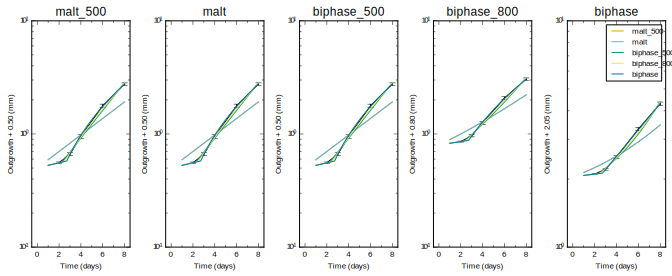

In [15]:
time = sp.linspace(1, 8)

minuit_names = ['malt_500', 'malt', 'biphase_500', 'biphase_800', 'biphase'] 

fig, axs = plt.subplots(1, len(minuit_names), figsize=(3*80/25.4,100.0/25.4), sharex = True)
fig.patch.set_alpha(1.0)

for ax, name in zip(axs, minuit_names):
    M = minuits[name]
    L0plot = M.values['L0']
    ax.errorbar(sp.array(mean_outgrowth.index)[1:],
                sp.array(mean_outgrowth['length', 'mean'])[1:]+ L0plot,
                sp.array(mean_outgrowth['length', 'sem'])[1:]
               )
    for name_plot in minuit_names:
        ax.plot(time, sp.vectorize(minuits[name_plot].fcn.f)(time, **minuits[name_plot].values) + L0plot,
                label = name_plot)
        
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Outgrowth + {0:.2f} (mm)'.format(L0plot))
    ax.set_title(name)

    ax.set_xlim(-0.5, 8.5)
    ax.set_xticks([1, 3, 5, 7], minor=True)
    ax.set_yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

only the fixed 500 models

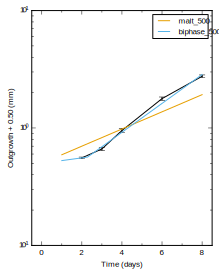

In [16]:
time = sp.linspace(1, 8)

minuit_names = ['malt_500', 'biphase_500'] 

fig, ax = plt.subplots(1, 1, figsize=(80/25.4,100.0/25.4), sharex = True)
fig.patch.set_alpha(1.0)

M = minuits[name]
L0plot = 0.5
ax.errorbar(sp.array(mean_outgrowth.index)[1:],
            sp.array(mean_outgrowth['length', 'mean'])[1:]+ L0plot,
            sp.array(mean_outgrowth['length', 'sem'])[1:]
           )
for name_plot in minuit_names:
    ax.plot(time, sp.vectorize(minuits[name_plot].fcn.f)(time, **minuits[name_plot].values) + L0plot,
            label = name_plot)

ax.set_xlabel('Time (days)')
ax.set_ylabel('Outgrowth + {0:.2f} (mm)'.format(L0plot))

ax.set_xlim(-0.5, 8.5)
ax.set_xticks([1, 3, 5, 7], minor=True)
ax.set_yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

#### GOF

In [17]:
def free_parameters(minuit):
    return int(len(minuit.values) - sp.sum([minuit.is_fixed(p) for p in minuit.values.iterkeys()]))

In [18]:
def GOF(minuit):
    ddof = minuit.fcn.data_len - free_parameters(minuit)
    p = 1 - sp.stats.chi2.cdf(M.fval, ddof)
    return p

In [19]:
for name, M in minuits.iteritems():
    print name
    print "p: {0:.2g}".format(GOF(M))

malt_500
p: 0
biphase_500
p: 0.0022
malt
p: 0
biphase_800
p: 0.059
biphase
p: 0.43


#### AIC

In [20]:
def AIC_SSE(minuit):
    SSE = minuit.fval
    ## only works if no fixed paramters are used
    k = free_parameters(minuit)
    AIC = 2 * k + SSE
    return AIC

def AICc_SSE(minuit):
    try:
        AICv = AIC_SSE(minuit)
        k = free_parameters(minuit)
        n = minuit.fcn.data_len
        AICc = AICv + 2 * k * (k + 1) / (n - k - 1)
    except:
        AICc = sp.nan
    
    return AICc

In [21]:
for name, M in minuits.iteritems():
    print name
    print 'AIC:  {}'.format(AIC_SSE(M))
    print 'AICc: {}'.format(AICc_SSE(M))

malt_500
AIC:  503.994752294
AICc: 504.994752294
biphase_500
AIC:  18.195768939
AICc: 42.195768939
malt
AIC:  505.994752553
AICc: 511.994752553
biphase_800
AIC:  11.6493115912
AICc: 35.6493115912
biphase
AIC:  8.61397311082
AICc: nan


# ML approach

In [22]:
times = sp.array(outgrowth.query('time > 0')['time'].astype(int))
lengths = sp.array(outgrowth.query('time > 0')['length'])

In [23]:
@numba.jit
def negloglike(L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8):
    loglike = 0.0 
    
        
    
    Lexps = sp.empty(len(times))
    Lmodels = sp.empty(len(times))
    sigmas = sp.empty(len(times))
    for i, (time, length) in enumerate(zip(times, lengths)):
        Lexp = length       
        Lmodel = biphase_model(float(time), L0, r1, r2, tswitch)
        if time == 2:
            sigma = sigma2
        elif time == 3:
            sigma = sigma3
        elif time == 4:
            sigma = sigma4
        elif time == 6:
            sigma = sigma6
        elif time == 8:
            sigma = sigma8
        Lexps[i] = Lexp
        Lmodels[i] = Lmodel
        sigmas[i] = sigma
        
            
    loglike = sp.stats.norm.logpdf(Lexps, loc=Lmodels, scale=sigmas).sum()
    return -loglike
negloglike.data_len = len(time)

In [24]:
def generate_initial():
    L0 = sp.random.uniform(0.5, 3)
    r1 = sp.random.uniform(0, 1)
    r2 = sp.random.uniform(0, 1)
    tswitch = sp.random.uniform(0, 8)
    sigma2 = sp.random.uniform(0.01, 1)
    sigma3 = sp.random.uniform(0.01, 1)
    sigma4 = sp.random.uniform(0.01, 1)
    sigma6 = sp.random.uniform(0.01, 1)
    sigma8 = sp.random.uniform(0.01, 1)
    return L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8

In [25]:
N = 10

In [26]:
minuits = {}

## Fit with Malthusian growth model

In [27]:
def M_maker(print_level = 0):
    return iminuit.Minuit(negloglike, errordef=0.5,
                               L0 = L0, error_L0 = 0.01, limit_L0 = (0.5, None), fix_L0 = fix_L0,
                               r1 = r1, error_r1 = 0.01, limit_r1 = (0, None), fix_r1 = False,
                               r2 = r2, error_r2 = 0.01, limit_r2 = (0, None), fix_r2 = fix_r2,
                               tswitch = tswitch, error_tswitch = 0.1, limit_tswitch = (0, None), fix_tswitch = fix_tswitch,
                               sigma2 = sigma2, error_sigma2 = 0.01, limit_sigma2 = (0, None),
                               sigma3 = sigma3, error_sigma3 = 0.01, limit_sigma3 = (0, None),
                               sigma4 = sigma4, error_sigma4 = 0.01, limit_sigma4 = (0, None),
                               sigma6 = sigma6, error_sigma6 = 0.01, limit_sigma6 = (0, None),
                               sigma8 = sigma8, error_sigma8 = 0.01, limit_sigma8 = (0, None),
                               print_level = print_level
                              )
    return M

### Assuming $L_0 = 500 \mu m$

In [28]:
fval = sp.inf
L0_best, r1_best, r2_best, tswitch_best = sp.nan, sp.nan, sp.nan, sp.nan, 
for i in range(N):
    L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8 = generate_initial()
    L0 = 0.5
    tswitch = 1e99
    fix_L0 = True
    fix_r2 = True
    fix_tswitch = True
    M = M_maker()
    M.migrad();
    if (M.fval < fval) and M.migrad_ok():
        fval = M.fval
        L0_best, r1_best, r2_best, tswitch_best, sigma2_best, sigma3_best, sigma4_best, sigma6_best, sigma8_best = L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8

L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8 = L0_best, r1_best, r2_best, tswitch_best, sigma2_best, sigma3_best, sigma4_best, sigma6_best, sigma8_best
minuits['malt_500'] = M_maker(print_level=1)
minuits['malt_500'].migrad();

FCN = -5.67347098769 
 TOTAL NCALL = 499 
 NCALLS = 499 
 
 
 EDM = 1.12444702903e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.000000e-02,0.000000e+00,0.000000e+00,0.5,,FIXED
2,r1,2.108757e-01,2.945246e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,7.924242e-01,1.000000e-02,0.000000e+00,0.000000e+00,0.0,,FIXED
4,tswitch,1.000000e+99,1.000000e-01,0.000000e+00,0.000000e+00,0.0,,FIXED
5,sigma2,2.071983e-01,5.188872e-02,0.000000e+00,0.000000e+00,0.0,,
6,sigma3,2.826228e-01,7.576418e-02,0.000000e+00,0.000000e+00,0.0,,
7,sigma4,2.371410e-01,6.037435e-02,0.000000e+00,0.000000e+00,0.0,,
8,sigma6,1.503360e-01,3.754489e-02,0.000000e+00,0.000000e+00,0.0,,
9,sigma8,1.993254e-01,5.277927e-02,0.000000e+00,0.000000e+00,0.0,,


### Not assuming $L_0 = 500 \mu m$

In [29]:
fval = sp.inf
L0_best, r1_best, r2_best, tswitch_best = sp.nan, sp.nan, sp.nan, sp.nan, 
for i in range(N):
    L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8 = generate_initial()
    tswitch = 1e99
    fix_L0 = False
    fix_r2 = True
    fix_tswitch = True
    M = M_maker()
    M.migrad();
    if (M.fval < fval) and M.migrad_ok():
        fval = M.fval
        L0_best, r1_best, r2_best, tswitch_best, sigma2_best, sigma3_best, sigma4_best, sigma6_best, sigma8_best = L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8

L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8 = L0_best, r1_best, r2_best, tswitch_best, sigma2_best, sigma3_best, sigma4_best, sigma6_best, sigma8_best
minuits['malt'] = M_maker(print_level=1)
minuits['malt'].migrad();

FCN = -5.67347109627 
 TOTAL NCALL = 912 
 NCALLS = 912 
 
 
 EDM = 3.89514219141e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.896210e-02,0.000000e+00,0.000000e+00,0.5,,
2,r1,2.108761e-01,2.945043e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,9.261837e-02,1.000000e-02,0.000000e+00,0.000000e+00,0.0,,FIXED
4,tswitch,1.000000e+99,1.000000e-01,0.000000e+00,0.000000e+00,0.0,,FIXED
5,sigma2,2.071907e-01,5.188403e-02,0.000000e+00,0.000000e+00,0.0,,
6,sigma3,2.826370e-01,7.577243e-02,0.000000e+00,0.000000e+00,0.0,,
7,sigma4,2.371596e-01,6.038433e-02,0.000000e+00,0.000000e+00,0.0,,
8,sigma6,1.503377e-01,3.754589e-02,0.000000e+00,0.000000e+00,0.0,,
9,sigma8,1.993122e-01,5.277112e-02,0.000000e+00,0.000000e+00,0.0,,


## Fit with Biphase

### Assuming $L_0 = 500 \mu m$

In [30]:
fval = sp.inf
L0_best, r1_best, r2_best, tswitch_best = sp.nan, sp.nan, sp.nan, sp.nan, 
for i in range(N):
    L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8 = generate_initial()
    L0 = 0.5
    fix_L0 = True
    fix_r2 = False
    fix_tswitch = False
    M = M_maker()
    M.migrad();
    if (M.fval < fval) and M.migrad_ok():
        fval = M.fval
        L0_best, r1_best, r2_best, tswitch_best, sigma2_best, sigma3_best, sigma4_best, sigma6_best, sigma8_best = L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8

L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8 = L0_best, r1_best, r2_best, tswitch_best, sigma2_best, sigma3_best, sigma4_best, sigma6_best, sigma8_best
minuits['biphase_500'] = M_maker(print_level=1)
minuits['biphase_500'].migrad();

FCN = -36.4485646119 
 TOTAL NCALL = 1009 
 NCALLS = 1009 
 
 
 EDM = 4.23940155967e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.000000e-02,0.000000e+00,0.000000e+00,0.5,,FIXED
2,r1,5.353306e-02,7.568087e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,2.820000e-01,8.538232e-03,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.319797e+00,1.801966e-01,0.000000e+00,0.000000e+00,0.0,,
5,sigma2,2.382876e-02,5.955491e-03,0.000000e+00,0.000000e+00,0.0,,
6,sigma3,5.578702e-02,1.738867e-02,0.000000e+00,0.000000e+00,0.0,,
7,sigma4,1.172181e-01,3.052562e-02,0.000000e+00,0.000000e+00,0.0,,
8,sigma6,2.347106e-01,6.369190e-02,0.000000e+00,0.000000e+00,0.0,,
9,sigma8,1.982703e-01,5.322690e-02,0.000000e+00,0.000000e+00,0.0,,


### Not assuming $L_0 = 500 \mu m$

In [48]:
fval = sp.inf
L0_best, r1_best, r2_best, tswitch_best = sp.nan, sp.nan, sp.nan, sp.nan, 
for i in range(N):
    L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8 = generate_initial()
#     L0 = 2.5
#     r1 = 0.1
#     r2 = 0.1
    fix_L0 = False
    fix_r2 = False
    fix_tswitch = False
    M = M_maker()
    M.migrad();
    if (M.fval < fval) and M.migrad_ok():
        fval = M.fval
        L0_best, r1_best, r2_best, tswitch_best, sigma2_best, sigma3_best, sigma4_best, sigma6_best, sigma8_best = L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8

L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8 = L0_best, r1_best, r2_best, tswitch_best, sigma2_best, sigma3_best, sigma4_best, sigma6_best, sigma8_best
minuits['biphase'] = M_maker(print_level=1)
minuits['biphase'].migrad();

FCN = -41.1448012583 
 TOTAL NCALL = 1551 
 NCALLS = 1551 
 
 
 EDM = 8.55324836078e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,2.050564e+00,1.037949e+00,0.000000e+00,0.000000e+00,0.5,,
2,r1,1.359121e-02,7.200116e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,1.339208e-01,4.760449e-02,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.715028e+00,1.090021e-01,0.000000e+00,0.000000e+00,0.0,,
5,sigma2,2.382728e-02,5.954674e-03,0.000000e+00,0.000000e+00,0.0,,
6,sigma3,5.115620e-02,1.372308e-02,0.000000e+00,0.000000e+00,0.0,,
7,sigma4,1.120192e-01,2.864722e-02,0.000000e+00,0.000000e+00,0.0,,
8,sigma6,1.523934e-01,3.888274e-02,0.000000e+00,0.000000e+00,0.0,,
9,sigma8,1.916659e-01,4.796311e-02,0.000000e+00,0.000000e+00,0.0,,


## Model comparison

In [44]:
def plot_model(fig, ax, time, M, label = None, L0plot = 0, color = 'black', ls = '-', lengthscale = 1.0):
    ax.plot(time, 
            lengthscale * sp.vectorize(biphase_model)(time, M.values['L0'], M.values['r1'], M.values['r2'], M.values['tswitch']) + L0plot,
           color = color,
           label = label, ls = ls, lw = 1.5)
    errortime = [2, 3, 4, 6, 8]
    sigmas = lengthscale * sp.array([M.values['sigma2'], M.values['sigma3'], M.values['sigma4'], M.values['sigma6'], M.values['sigma8']])
    ax.errorbar(errortime, 
                lengthscale * sp.vectorize(biphase_model)(errortime, M.values['L0'], M.values['r1'],
                                            M.values['r2'], M.values['tswitch']) + L0plot,
               sigmas,
               ls = '', color = color)
    

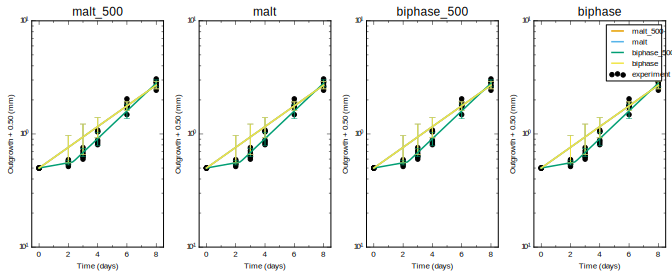

In [33]:
time = sp.linspace(0, 8)

minuit_names = ['malt_500', 'malt', 'biphase_500', 'biphase'] 

fig, axs = plt.subplots(1, len(minuit_names), figsize=(len(minuit_names)*60/25.4,100.0/25.4), sharex = True, squeeze=False)
fig.patch.set_alpha(1.0)

for ax, name in zip(axs[0], minuit_names):
    M = minuits[name]
    L0plot = M.values['L0']
    ax.scatter(outgrowth['time'], outgrowth['length'] + L0plot, label = 'experiment', color = 'black')
    for i, name_plot in enumerate(minuit_names):
        plot_model(fig, ax, time, minuits[name_plot], name_plot, L0plot, color=colorcycle[i+1])
        
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Outgrowth + {0:.2f} (mm)'.format(L0plot))
    ax.set_title(name)

    ax.set_xlim(-0.5, 8.5)
    ax.set_xticks([1, 3, 5, 7], minor=True)
    ax.set_yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

In [34]:
import seaborn
seaborn.set_context('paper')
seaborn.set_style('ticks')
seaborn.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})

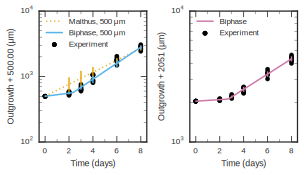

In [53]:
lengthscale = 1000.0
labels = {'malt_500': u'Malthus, 500 μm', 'biphase_500': u'Biphase, 500 μm                      ', 'biphase': 'Biphase'}
colors = {'malt_500': colorcycle[1], 'biphase_500': colorcycle[2], 'biphase': colorcycle[7]}
linestyles = {'malt_500': ':', 'biphase_500': '-', 'biphase': '-'}
time = sp.linspace(0, 8)

fig, axs = plt.subplots(1, 2, figsize=(2*55/25.4,65.0/25.4), sharex = True)
fig.patch.set_alpha(1.0)

ax = axs[0]
L0plot = 0.5 * lengthscale
ax.scatter(outgrowth['time'], lengthscale * outgrowth['length'] + L0plot, label = 'Experiment             ', color = 'black')
for i, name_plot in enumerate(['malt_500', 'biphase_500']):
    plot_model(fig, ax, time, minuits[name_plot], labels[name_plot], L0plot, color=colors[name_plot], ls = linestyles[name_plot], lengthscale = lengthscale)
ax.set_xlabel('Time (days)')
ax.set_ylabel(u'Outgrowth + {0:.2f} (μm)'.format(L0plot))    
ax.legend(loc = 'upper left')
ax.set_yscale('log')

    
ax = axs[1]
L0plot = lengthscale * minuits['biphase'].values['L0']
ax.scatter(outgrowth['time'], lengthscale * outgrowth['length'] + L0plot, label = 'Experiment             ', color = 'black')
for i, name_plot in enumerate(['biphase']):
    plot_model(fig, ax, time, minuits[name_plot], labels[name_plot], L0plot, color=colors[name_plot], lengthscale = lengthscale)

ax.set_xlabel('Time (days)')
ax.set_ylabel(u'Outgrowth + {0:.0f} (μm)'.format(L0plot))
ax.legend(loc = 'upper left')

ax.set_xlim(-0.5, 8.5)
ax.set_xticks([1, 3, 5, 7], minor=True)
ax.set_yscale('log')

plt.tight_layout()

exportname = 'outgrowth_proliferation_fit'
plt.savefig('{}.svg'.format(exportname))
# os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))


plt.show()

### AIC

In [36]:
def AIC_loglike(minuit):
    loglike = -minuit.fval
    ## only works if no fixed paramters are used
    k = free_parameters(minuit)
    AIC = - 2 * loglike + 2 * k 
    return AIC

def AICc_loglike(minuit):
    try:
        AICv = AIC_loglike(minuit)
        k = free_parameters(minuit)
        n = minuit.fcn.data_len
        AICc = AICv + 2 * k * (k + 1) / (n - k - 1)
    except:
        AICc = sp.nan
    
    return AICc

In [37]:
for name, M in minuits.iteritems():
    print name
    print 'AIC:  {}'.format(AIC_loglike(M))
    print 'AICc: {}'.format(AICc_loglike(M))

malt_500
AIC:  0.653058024611
AICc: 1.65305802461
biphase_500
AIC:  -56.8971292237
AICc: -53.8971292237
malt
AIC:  2.65305780746
AICc: 4.65305780746
biphase
AIC:  6.65305806347
AICc: 10.6530580635


`biphase` has the best AICc. Calculate evidence ratios:

In [38]:
def ER_loglike(minuit1, minuit2):
    AIC1 = AICc_loglike(minuit1)
    AIC2 = AICc_loglike(minuit2)
    dAIC = AIC2 - AIC1
    return sp.exp(0.5 * dAIC)

In [39]:
for name in ['malt', 'malt_500', 'biphase_500']:
    print 'ER ({0:11s}): {1:.2f}'.format(name, ER_loglike(minuit1=minuits['biphase'], minuit2=minuits[name]))

ER (malt       ): 0.05
ER (malt_500   ): 0.01
ER (biphase_500): 0.00


### ML summary

Parameter values

In [40]:
models = ['Malthus, $500 \unit{\mu m}$'] + 3 * ['Biphase, $500 \unit{\mu m}$'] + 4* [labels['biphase']]
parameters = ['$r\ (\unit{day^{-1}})$',
              '$r_1\ (\unit{per\ day}$)', '$r_2\ (\unit{per\ day})$', '$t_{switch}\ (\unit{ days})$', 
              '$r_1\ (\unit{per\ day}$)', '$r_2\ (\unit{per\ day})$', '$t_{switch}\ (\unit{ days})$', '$L_0\ (\unit{ mm})$']
para_df = pd.DataFrame(index = pd.MultiIndex.from_arrays([models, parameters], names=['Model', 'Parameters']),
            columns = ['Values', '68\% error'])

def values(M, p):
    error = M.errors[p]
    sigfig = int(sp.ceil(-sp.log10(error)))
    value = sp.around(M.values[p], sigfig)
    return "{0}".format(value), "$\pm{0:.1g}$".format(error)

para_df.iloc[0] = values(minuits['malt_500'], 'r1')
para_df.iloc[1] = values(minuits['biphase_500'], 'r1')
para_df.iloc[2] = values(minuits['biphase_500'], 'r2')
para_df.iloc[3] = values(minuits['biphase_500'], 'tswitch')
para_df.iloc[4] = values(minuits['biphase'], 'r1')
para_df.iloc[5] = values(minuits['biphase'], 'r2')
para_df.iloc[6] = values(minuits['biphase'], 'tswitch')
para_df.iloc[7] = values(minuits['biphase'], 'L0')
print para_df.to_latex(escape=False)

\begin{tabular}{llll}
\toprule
        &                     & Values &  68\% error \\
Model & Parameters &        &             \\
\midrule
Malthus, $500 \unit{\mu m}$ & $r\ (\unit{day^{-1}})$ &  0.211 &  $\pm0.003$ \\
Biphase, $500 \unit{\mu m}$ & $r_1\ (\unit{per\ day}$) &  0.054 &  $\pm0.008$ \\
        & $r_2\ (\unit{per\ day})$ &  0.282 &  $\pm0.009$ \\
        & $t_{switch}\ (\unit{ days})$ &    2.3 &    $\pm0.2$ \\
Biphase & $r_1\ (\unit{per\ day}$) &  0.211 &  $\pm0.003$ \\
        & $r_2\ (\unit{per\ day})$ &    1.0 &      $\pm1$ \\
        & $t_{switch}\ (\unit{ days})$ &   17.0 &      $\pm2$ \\
        & $L_0\ (\unit{ mm})$ &    0.5 &   $\pm0.02$ \\
\bottomrule
\end{tabular}



In [41]:
para_df

Values  68\% error
Model                       Parameters                                     
Malthus, $500 \unit{\mu m}$ $r\ (\unit{day^{-1}})$        0.211  $\pm0.003$
Biphase, $500 \unit{\mu m}$ $r_1\ (\unit{per\ day}$)      0.054  $\pm0.008$
                            $r_2\ (\unit{per\ day})$      0.282  $\pm0.009$
                            $t_{switch}\ (\unit{ days})$    2.3    $\pm0.2$
Biphase                     $r_1\ (\unit{per\ day}$)      0.211  $\pm0.003$
                            $r_2\ (\unit{per\ day})$        1.0      $\pm1$
                            $t_{switch}\ (\unit{ days})$   17.0      $\pm2$
                            $L_0\ (\unit{ mm})$             0.5   $\pm0.02$

$\ln L$, AICc, ER

In [42]:
models = pd.Index(['Malthus, $500 \unit{\mu m}$'] + ['Biphase, $500 \unit{\mu m}$'] + [labels['biphase']], name = 'Models')
model_df = pd.DataFrame(index = models, columns = ['$\ln L$', 'k','\\ac{AICc}', '\\ac{ER}'])

def values(M):
    loklike = -M.fval
    k = free_parameters(M)
    AICc = AICc_loglike(M)
    ER = ER_loglike(minuits['biphase'], M)
    return "{0:.2f}".format(loklike),"{0}".format(k),"{0:.2f}".format(AICc),"{0:.2g}".format(ER)

model_df.iloc[0] = values(minuits['malt_500'])
model_df.iloc[1] = values(minuits['biphase_500'])
model_df.iloc[2] = values(minuits['biphase'])

print model_df.to_latex(escape=False)

\begin{tabular}{lllll}
\toprule
{} & $\ln L$ &  k & \ac{AICc} &  \ac{ER} \\
Models                      &         &    &           &          \\
\midrule
Malthus, $500 \unit{\mu m}$ &    5.67 &  6 &      1.65 &    0.011 \\
Biphase, $500 \unit{\mu m}$ &   36.45 &  8 &    -53.90 &  9.6e-15 \\
Biphase                     &    5.67 &  9 &     10.65 &        1 \\
\bottomrule
\end{tabular}

